# Part 4: Sentiment of the artists and communities

The questions below are based on Lecture 8

* Calculate the sentiment of the band/artist pages (it is OK to work with the sub-network of artists-with-genre) and describe your findings using stats and visualization, inspired by the first exercise of week 8.
* Discuss the sentiment of the communities. Do the findings using TF-IDF during Lecture 7 help you understand your results?

In [8]:
import os
import json
import nltk
import networkx as nx
from nltk.tokenize import word_tokenize
from collections import Counter
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

nltk.download('punkt') 

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\Zosia\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [9]:
G = nx.read_graphml("Rock_Music_Network_w_Genres.graphml")

*Exercise*: Sentiment distribution. 
> 
> * Download the LabMT wordlist. It's available as supplementary material from [Temporal Patterns of Happiness and Information in a Global Social Network: Hedonometrics and Twitter](http://journals.plos.org/plosone/article?id=10.1371/journal.pone.0026752) (Data Set S1). Describe briefly how the list was generated.
> * Based on the LabMT word list, write a function that calculates sentiment given a list of tokens (the tokens should be lower case, etc).
> * Iterage over the nodes in your network, tokenize each page, and calculate sentiment every single page. Now you have sentiment as a new nodal property.
> * Calculate the average sentiment across all the pages. Also calculate the median, variance, 25th percentile, 75th percentile.
> * Remember histograms? Create a histogram of all of the artists's associated page-sentiments. (And make it a nice histogram - use your histogram making skills from Week 2). Add the mean, meadian, ect from above to your plot.
> * Who are the 10 artists with happiest and saddest pages?

In [10]:
# functions

def tokenize_text(text):
    # tokenizes the band page text using the nltk library method word_tokenize()
    text = text.lower()
    tokens = word_tokenize(text)
    return tokens

def load_happiness_dict(filepath):
    # loads the LabMT dataset and creates a dictionary from the columns 'word' and 'happiness_average'
    df = pd.read_csv(filepath, sep='\t', skiprows=2)
    df = df[['word', 'happiness_average']]

    # drop any missing values just in case
    df = df.dropna(subset=['word', 'happiness_average'])

    happiness_dict = pd.Series(df.happiness_average.values, index=df.word).to_dict()

    return happiness_dict

def calculate_sentiment(tokens, happiness_dict):
    # implements the sentiment formula to get a sentiment (happiness) score

    # count frequencies of all tokens
    token_counts = Counter(tokens)

    numerator = 0.0
    denominator = 0

    for word, happiness_value in happiness_dict.items():
        if word in token_counts:
            freq = token_counts[word]
            numerator += happiness_value * freq
            denominator += freq

    if denominator == 0:
        return None

    return numerator / denominator

In [11]:
# the script that iterates over the nodes and calculates the sentiment for every music artist/band 

# the folder containing json files of all bands wikipedia pages
bands_folder = 'bands'

# a list of nodes for the iteration
nodes = set(G.nodes())

# filepath to the LabMT dataset
labMT_filepath = 'Data_Set_S1.txt'

# here we store the token list for every band page
band_tokens = {}

for filename in os.listdir(bands_folder):
    # first part of the loop handles the json files, so we can get the wikitext stored inside
    if filename.endswith('.json'):
        filepath = os.path.join(bands_folder, filename)
        with open(filepath, 'r', encoding='utf-8') as f:
            data = json.load(f)

        # get the artist name and wikitext
        artist_name = data.get('page')
        wikitext = data.get('wikitext', '')

        # tokenize the bands wikitext and provide a dictionary band_tokens, where an artist is a key a list of tokens is a value
        # as we use a folder of bands json file that was used to create an original network, in the current graph some of the bands are not present
        if artist_name in nodes:
            tokens = tokenize_text(wikitext)
            band_tokens[artist_name] = tokens
        else:
            print(f"Skipping {artist_name} (not in graph)")
            pass

# the mapping: word -> average_happines
happiness_dict = load_happiness_dict(labMT_filepath)

# straightforward use of the the calculate_sentiment() function to get the sentiment scores
sentiment_scores = {}
for band, tokens in band_tokens.items():
    sentiment = calculate_sentiment(tokens, happiness_dict)
    sentiment_scores[band] = sentiment

print(f"Sentiment scores: {sentiment_scores}")


Skipping Dallas_Green_(musician) (not in graph)
Skipping Dr._Hook_&_the_Medicine_Show (not in graph)
Skipping Electric_Light_Orchestra (not in graph)
Skipping Jet_(Australian_band) (not in graph)
Skipping Pat_Benatar (not in graph)
Skipping Poison_(American_band) (not in graph)
Skipping The_B-52's (not in graph)
Skipping The_Zombies (not in graph)
Skipping Van_Zant_(band) (not in graph)
Sentiment scores: {'38_Special_(band)': 5.605795950774114, '10cc': 5.5361298322392365, '10_Years_(band)': 5.614840940525586, '311_(band)': 5.635149425287355, '3_Doors_Down': 5.535544109878494, 'ABBA': 5.602567475618054, 'Accept_(band)': 5.528311582381734, 'AC/DC': 5.54866319590226, 'Adam_Ant': 5.582815196214868, 'Aerosmith': 5.568397328881476, 'AFI_(band)': 5.516055961070565, 'Air_Supply': 5.6987583352494795, 'Alanis_Morissette': 5.663687382297542, 'Alice_Cooper': 5.537671490027372, 'Alice_Cooper_(band)': 5.535676595744684, 'Alice_in_Chains': 5.501067954009434, 'Alter_Bridge': 5.63999416569428, 'Ambrosi

In [12]:
# average sentiment across all pages and the percentiles
sentiment_scores_list = list(sentiment_scores.values())

mean = sum(sentiment_scores_list) / len(sentiment_scores_list)
median = np.median(sentiment_scores_list)
var = np.var(sentiment_scores_list)
percentile_25 = np.percentile(sentiment_scores_list, 25)
percentile_75 = np.percentile(sentiment_scores_list, 75)

print(f'The statistics of the sentiment across all pages: \nMean:{mean} \nMedian:{median} \nVariance:{var} \n25th percentile:{percentile_25} \n75th percentile:{percentile_75}')

The statistics of the sentiment across all pages: 
Mean:5.568958058809201 
Median:5.569446820444506 
Variance:0.004097487133554876 
25th percentile:5.5283422920789596 
75th percentile:5.61320971150895


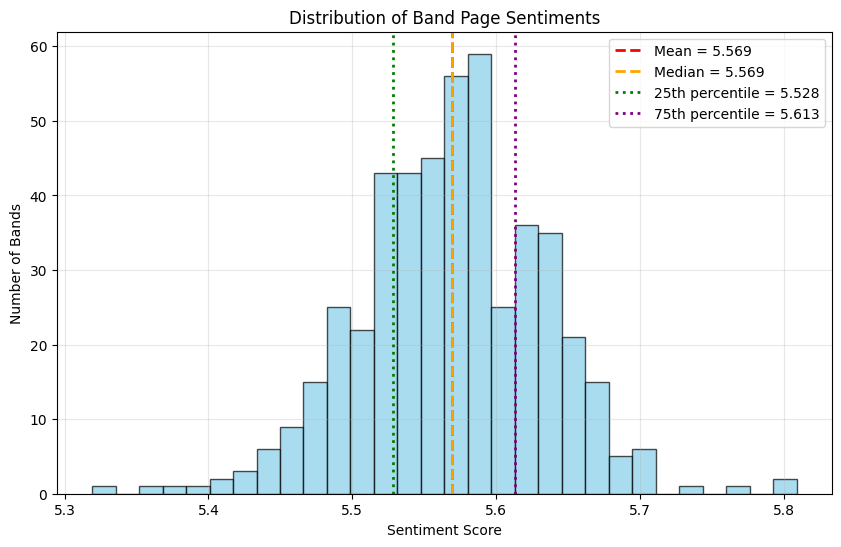

In [13]:
# the histogram of all bands pages sentiment scores with the statistics
plt.figure(figsize=(10, 6))
plt.hist(sentiment_scores_list, bins=30, color='skyblue', edgecolor='black', alpha=0.7)
plt.title("Distribution of Band Page Sentiments")
plt.xlabel("Sentiment Score")
plt.ylabel("Number of Bands")

# the statistics added visually as lines
plt.axvline(mean, color='red', linestyle='--', linewidth=2, label=f"Mean = {mean:.3f}")
plt.axvline(median, color='orange', linestyle='--', linewidth=2, label=f"Median = {median:.3f}")
plt.axvline(percentile_25, color='green', linestyle=':', linewidth=2, label=f"25th percentile = {percentile_25:.3f}")
plt.axvline(percentile_75, color='purple', linestyle=':', linewidth=2, label=f"75th percentile = {percentile_75:.3f}")

plt.legend()
plt.grid(alpha=0.3)
plt.show()

In [14]:
# 10 happiest artist pages according to their sentiment score
top_10 = sorted(sentiment_scores.items(), key=lambda x: x[1], reverse=True)[:10]

top_10


[('Tracy_Chapman', 5.808819494584836),
 ('Lenny_Kravitz', 5.799490572878895),
 ('Boys_Like_Girls', 5.772109638867239),
 ('Fun_(band)', 5.732162303664921),
 ('Living_Colour', 5.70139325842696),
 ('Air_Supply', 5.6987583352494795),
 ('The_Cardigans', 5.697486313868612),
 ('Kaiser_Chiefs', 5.695631868131869),
 ('Michael_Martin_Murphey', 5.6952954971857475),
 ('Icehouse_(band)', 5.695198987807686)]

In [15]:
# 10 saddest artist pages according to their sentiment score
bottom_10 = sorted(sentiment_scores.items(), key=lambda x: x[1], reverse=True)[-10:]

bottom_10

[('White_Zombie_(band)', 5.436992235390272),
 ('Ted_Nugent', 5.433358849148727),
 ('Skid_Row_(American_band)', 5.427068031306432),
 ('Gary_Glitter', 5.418742680546521),
 ('Canned_Heat', 5.405595188718373),
 ('Quiet_Riot', 5.400871831745454),
 ('Marilyn_Manson', 5.399925980152924),
 ('Rob_Zombie', 5.370735620190423),
 ('Rage_Against_the_Machine', 5.368000491581656),
 ('Five_Finger_Death_Punch', 5.319182528891913)]

*Exercise*: Community sentiment distribution. 
  
> * Last week we calculated the stuctural communities of the graph. For this exercise, we use those communities (just the 10 largest ones, or all your communities if you have fewer than 10). Specifically, you should calculate the average the average sentiment of the nodes in each community to find a *community level sentiment*. 
>   - Name each community by its three most connected bands. (Or feed the list of bands in each community and ask the LLM to come up with a good name for the community).
>   - What are the three happiest communities? (or the two happiest if you have 5 or fewer communities)
>   - what are the three saddest communities? (or the two happiest if you have 5 or fewer communities)
>   - Do these results confirm what you can learn about each community by comparing to the genres, checking out the word-clouds for each community, and reading the wiki-pages? 
> * Compare the sentiment of the happiest and saddest communities to the overall (entire network) distribution of sentiment that you calculated in the previous exercise. Are the communities very differenct from the average? Or do you find the sentiment to be quite similar across all of the communities?

In [16]:
communities = nx.community.louvain_communities(G)

In [17]:
# functions

def calculate_community_sentiment(G, community, sentiment_scores):
    #calculates the average sentiment of the nodes in the community
    
    scores = [
        sentiment_scores[node] 
        for node in community 
        if node in sentiment_scores and sentiment_scores[node] is not None
    ]

    avg_sentiment = np.mean(scores) if len(scores) > 0 else None
    return avg_sentiment

def label_community_by_top_nodes(G, community, top_n=3):
    # assigns a community label to each node; the name of the community is derived from the 3 most connected bands

    degrees = [(node, G.degree(node)) for node in community]
    top_nodes = sorted(degrees, key=lambda x: x[1], reverse=True)[:top_n]
    top_names = [n for n, _ in top_nodes]
    label = "-".join(top_names)
    node_to_label = {node: label for node in community}

    # set as node attribute
    nx.set_node_attributes(G, node_to_label, "community")

    # node_to_label is a mapping: node -> community label
    return label, node_to_label


In [18]:
community_sentiments = {}
for community in communities:
    label, node_label_mapping = label_community_by_top_nodes(G, community)    
    community_sentiment = calculate_community_sentiment(G, community, sentiment_scores)
    community_sentiments[label] = community_sentiment
    print(f'The {label} community has an average sentiment: {community_sentiment}')

The Queen_(band)-Metallica-Deep_Purple community has an average sentiment: 5.538785224829646
The Led_Zeppelin-Rush_(band)-Pink_Floyd community has an average sentiment: 5.5845139475031065
The Bob_Dylan-Jimi_Hendrix-Paul_McCartney community has an average sentiment: 5.564919901381028
The David_Bowie-U2-Nirvana_(band) community has an average sentiment: 5.589317256298413


In [19]:
top_2 = sorted(community_sentiments.items(), key=lambda x: x[1], reverse=True)[:2]
top_2

[('David_Bowie-U2-Nirvana_(band)', np.float64(5.589317256298413)),
 ('Led_Zeppelin-Rush_(band)-Pink_Floyd', np.float64(5.5845139475031065))]

In [20]:
bottom_2 = sorted(community_sentiments.items(), key=lambda x: x[1], reverse=True)[-2:]
bottom_2

[('Bob_Dylan-Jimi_Hendrix-Paul_McCartney', np.float64(5.564919901381028)),
 ('Queen_(band)-Metallica-Deep_Purple', np.float64(5.538785224829646))]

TODO:

>   - Do these results confirm what you can learn about each community by comparing to the genres, checking out the word-clouds for each community, and reading the wiki-pages? 
> * Compare the sentiment of the happiest and saddest communities to the overall (entire network) distribution of sentiment that you calculated in the previous exercise. Are the communities very differenct from the average? Or do you find the sentiment to be quite similar across all of the communities?